## UFC model to predict winner of fights

I will use the the ufc data from https://www.kaggle.com/rajeevw/ufcdata to build a model to predict the winner of fights.  Its hard to predict MMA fights since its a combination three martial arts, striking, wrestling and grappling.  The UFC has there own ranking model.  The higher ranked fighter alway fights out of red corner.  Lets see if we can make a model that does better than the UFC model.  Here each row in the data has prior information about the fighters in the Blue and Red corners such has strikes landed and damage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import tqdm
df = pd.read_csv('ufc_preprocessed_data.csv')

In [2]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Columns: 160 entries, Winner to R_Stance_Switch
dtypes: bool(1), float64(134), int64(24), object(1)
memory usage: 4.4+ MB


As we can see from the output, this dataset contains 3592 observations and 160 columns.

In [4]:
df=df.drop_duplicates(keep='first')

In [5]:
df.shape

(3592, 160)

There is data for $3592$ fights.  Each fights has $160$ variables.  

In [6]:
for i in df.columns:
    count = 0
    if df[i].isnull().sum() != 0:
        print(i)
        count = count +1
if count == 0:
    print('no null values')

no null values


Getting the number of unique values for each column of our data frame would help us decide which DataFrames might be categorical—if it's a small number, then it's likely to be categorical.

In [7]:
#for i in range (160):
    #print(i, df.columns[i],':',df.nunique()[i])

## EDA 
    
    There are total of 160 variables.
    
    Here we see that the first 3 variables indexed from [0:2] are categorical.  

    Then variables indexed from [3:68] and 135 are numerical features  about the fighter in the blue corner.

    And variables indexed from [69:134] and 136 are numerical features about the fighter in the red corner.    

    Variables indexed [137:150] are the result of weight class variable(categorical) that has been one hot encoded.

    Variables indexed [151:159] are the result fighter stance variable(categorical) that has been one hot encoded.



In [8]:
#df.columns[137:150]

In [9]:
#df.columns[151:159]

Lets look at blue variables first.

In [10]:
# Lets look at blue continuous 
blue_cont = df.iloc[:,3:68]
blue_cont['B_age'] = df['B_age']

We can try to separate the continuous and categorical feature. If a feature has less than 12 unique value then we can treat it as catagorical.  

In [11]:
blue_cat = pd.DataFrame()

for i in blue_cont.columns:
    if blue_cont[i].nunique() < 12:
        blue_cat.loc[:,i] = blue_cont[i]
        blue_cont = blue_cont.drop(i, axis = 1)
        #print(i, ': ' ,blue_cat[i].nunique())
        
print('cont : ',blue_cont.columns.nunique(), 'cat : ',blue_cat.columns.nunique())

cont :  60 cat :  6


In [12]:
# red cont
red_cont = df.iloc[:,69:134]
red_cont['R_age'] = df['R_age']
#red cat
red_cat = pd.DataFrame()

for i in red_cont.columns:
    if red_cont[i].nunique() < 12:
        red_cat.loc[:,i] = red_cont[i]
        red_cont = red_cont.drop(i, axis = 1)

print('R cont : ',red_cont.columns.nunique(), 'R cat : ',red_cat.columns.nunique())

R cont :  60 R cat :  6


Now that we identified the blue and red continuous features we can take a look at the distribution and see if we can get any insight about the data.

Lets look at the distributions in the features.

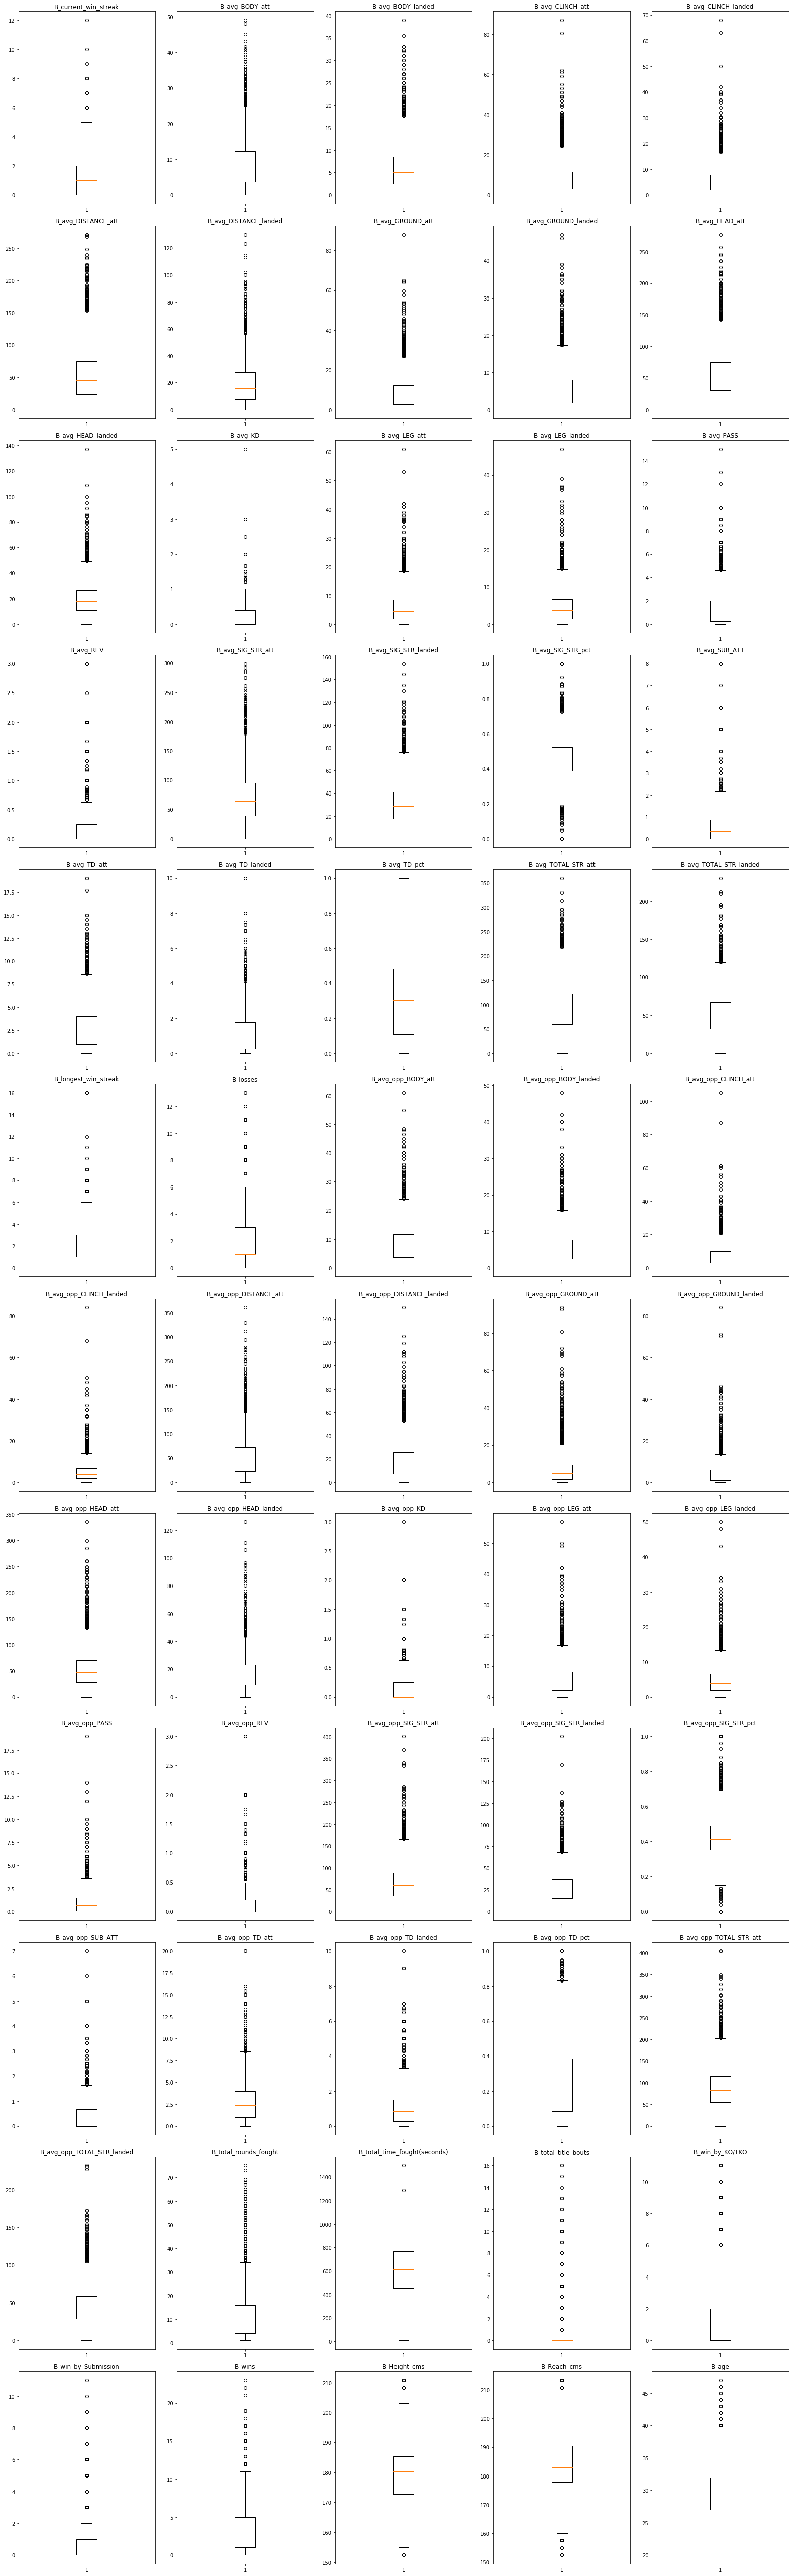

In [13]:
plt.figure(figsize=(22,77))
i=1
for feature in blue_cont.columns:
    plt.subplot(13,5,i)
    plt.boxplot(blue_cont[feature])
    plt.title(feature)
    i=i+1
plt.tight_layout()
plt.show()

We can identify outliers by z score.

In [14]:
from scipy.stats import zscore

threshold = 1.5
for feature in blue_cont.columns:
    z_scores = zscore(blue_cont[feature])
    print('For the feature ', feature)
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))
    #print("The score threshold is: {}".format(threshold))
    #print("The indices of the outliers:")
    #print(np.where(z_scores > threshold))
    #print('\n')

For the feature  B_current_win_streak
Number of outliers is: 232
For the feature  B_avg_BODY_att
Number of outliers is: 299
For the feature  B_avg_BODY_landed
Number of outliers is: 322
For the feature  B_avg_CLINCH_att
Number of outliers is: 248
For the feature  B_avg_CLINCH_landed
Number of outliers is: 240
For the feature  B_avg_DISTANCE_att
Number of outliers is: 296
For the feature  B_avg_DISTANCE_landed
Number of outliers is: 291
For the feature  B_avg_GROUND_att
Number of outliers is: 285
For the feature  B_avg_GROUND_landed
Number of outliers is: 267
For the feature  B_avg_HEAD_att
Number of outliers is: 281
For the feature  B_avg_HEAD_landed
Number of outliers is: 267
For the feature  B_avg_KD
Number of outliers is: 281
For the feature  B_avg_LEG_att
Number of outliers is: 271
For the feature  B_avg_LEG_landed
Number of outliers is: 289
For the feature  B_avg_PASS
Number of outliers is: 285
For the feature  B_avg_REV
Number of outliers is: 267
For the feature  B_avg_SIG_STR_at

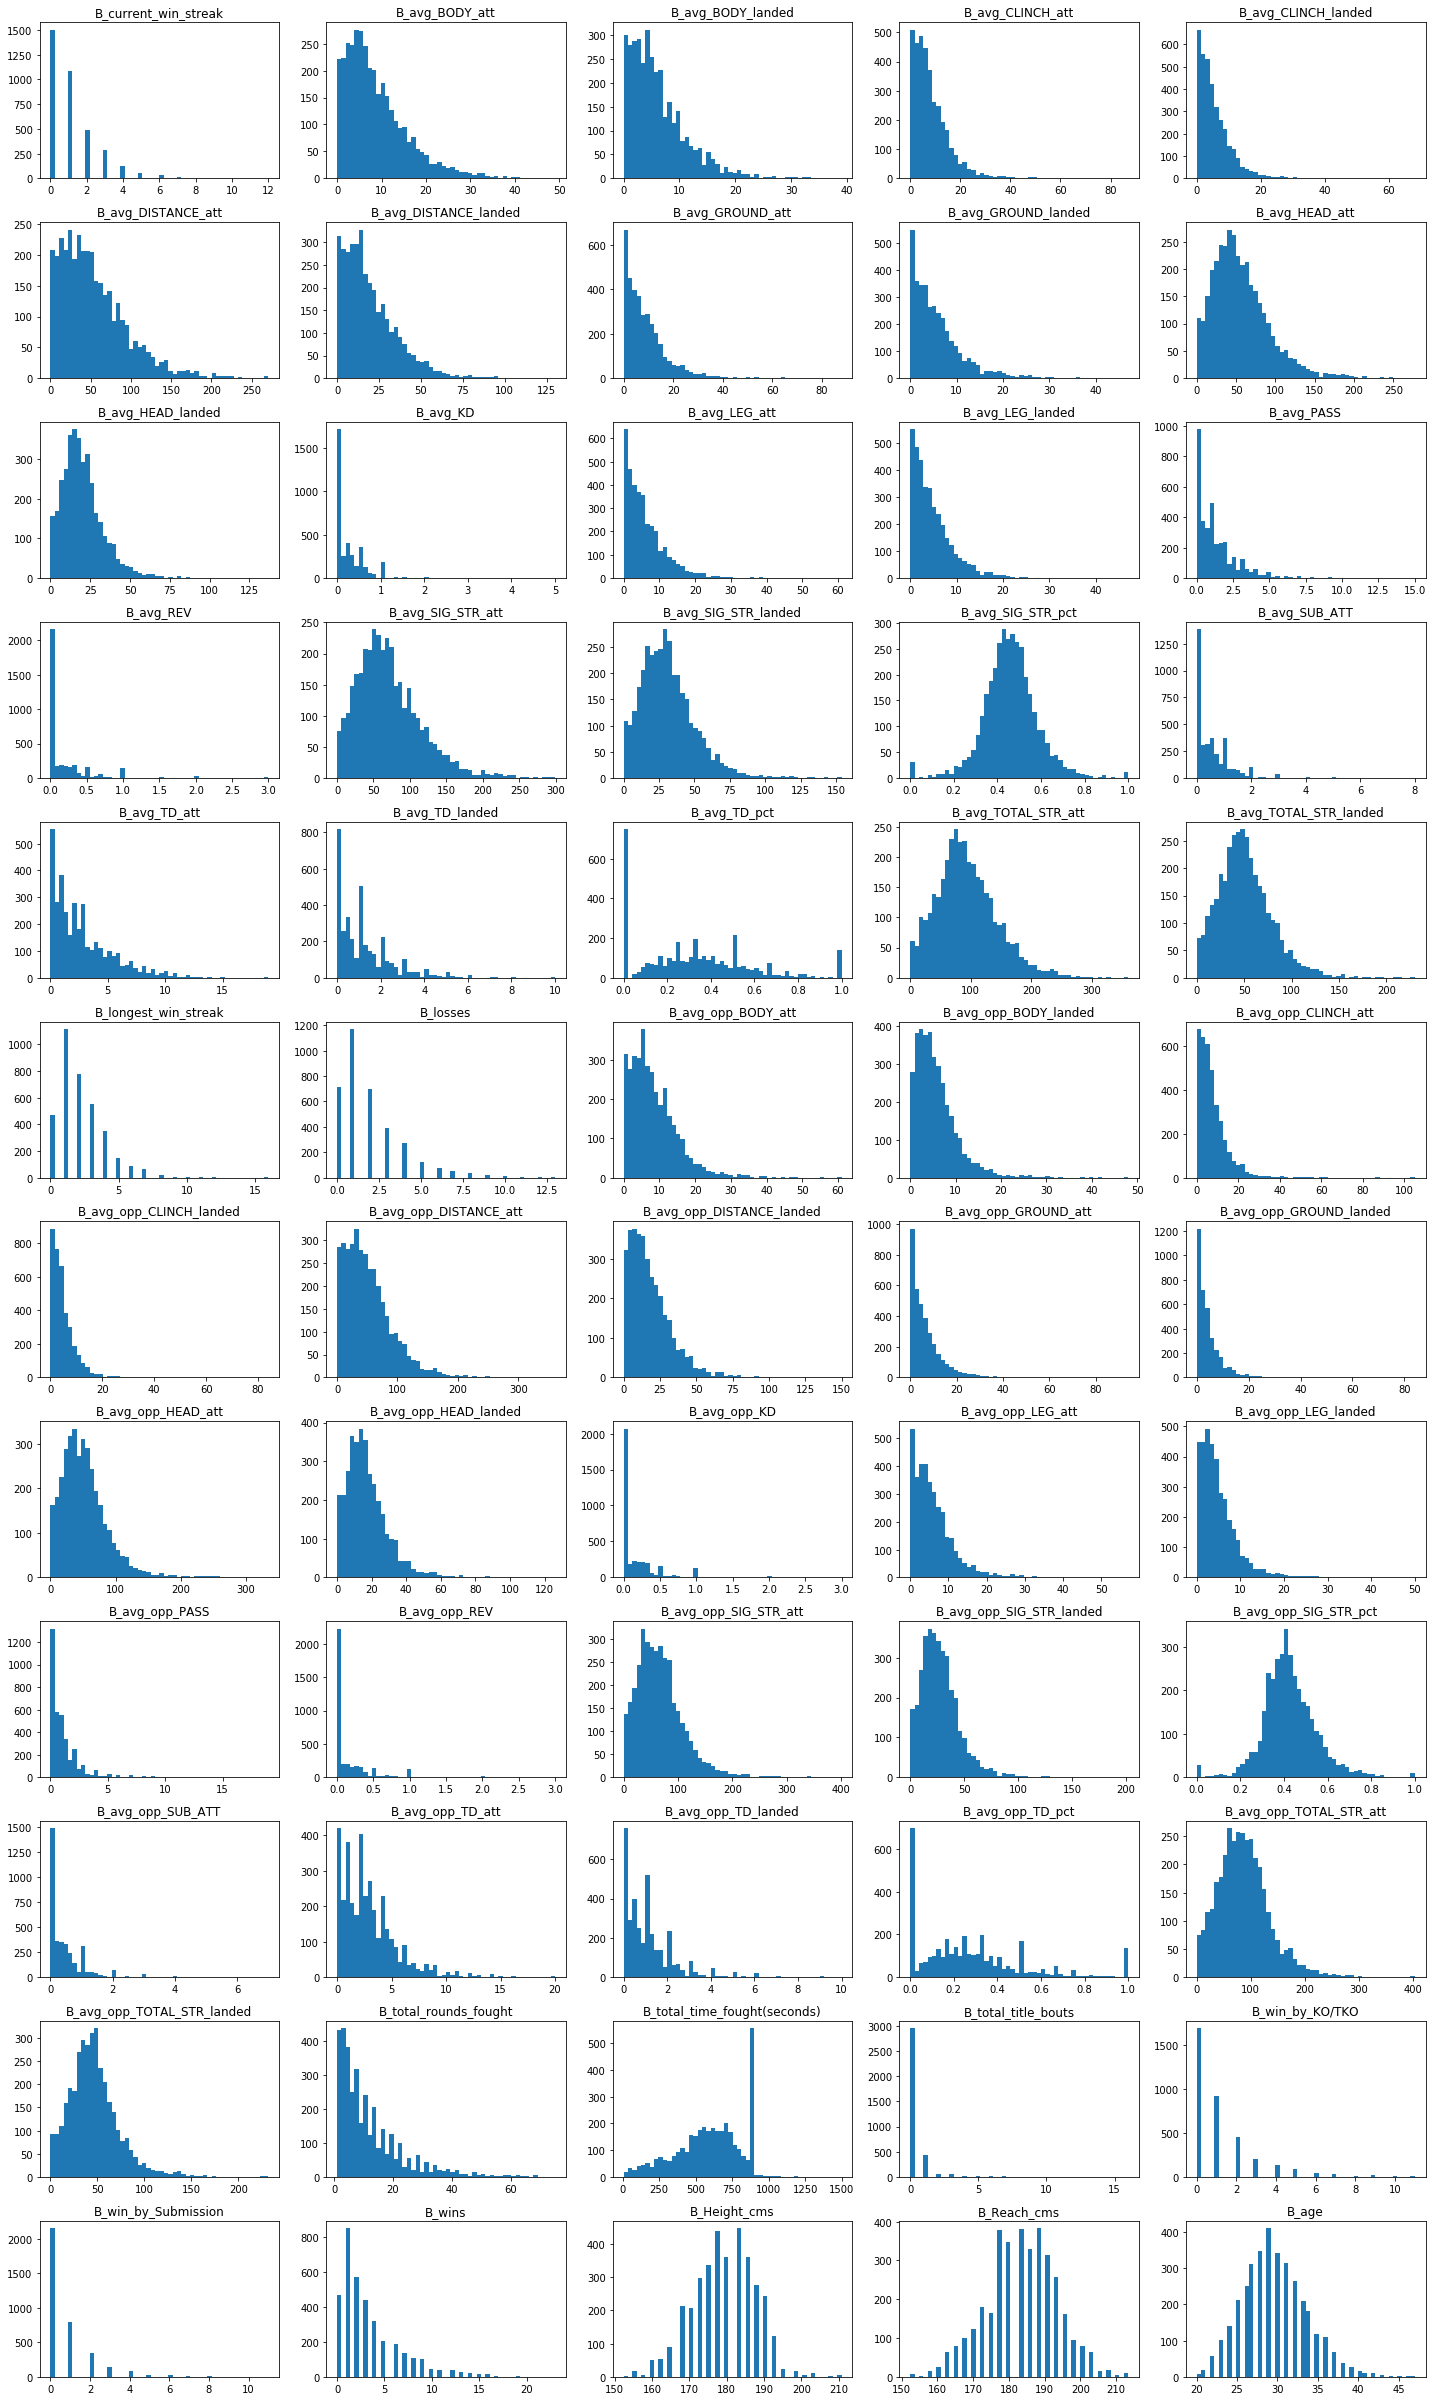

In [15]:
plt.figure(figsize=(20,36))
i=1
for feature in blue_cont.columns:
    plt.subplot(13,5,i)
    plt.hist(df.loc[:,feature], bins = 50)
    plt.title(feature)
    i=i+1
plt.tight_layout()
plt.show()

Looking at the distribution of the continuous features we can tell that most have a skew towards the left and have a long tail.

Many ML models are sensitive to the distribution. We can try and transform the data with a common monotonic function such as Log or square root.  This may inprove the accuracy of the model and reduce number of outliers.

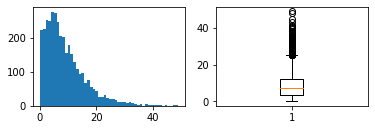

For the feature  B_avg_BODY_att
Number of outliers is: 299
The score threshold is: 1.5


In [16]:
#before transformation
plt.figsize=(22,77)
plt.subplot(2,2,1)
plt.hist(blue_cont['B_avg_BODY_att'], bins = 50)
plt.subplot(2,2,2)
plt.boxplot(blue_cont['B_avg_BODY_att'])
plt.show()

from scipy.stats import zscore
threshold = 1.5
z_scores = zscore(blue_cont['B_avg_BODY_att'])
print('For the feature ', 'B_avg_BODY_att')
print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

print("The score threshold is: {}".format(threshold))
    #print("The indices of the outliers:")
    #print(np.where(z_scores > threshold))
    #print('\n')

c:\users\jiedo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
c:\users\jiedo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


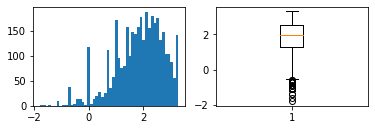

c:\users\jiedo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


For the log transformed feature of  B_avg_BODY_att_winsorized
Number of outliers is: 138
The score threshold is: 1.5


In [17]:
#Log trans
from scipy.stats.mstats import winsorize
#winsorize to 95% of data
B_avg_BODY_att_winsorized = winsorize(blue_cont['B_avg_BODY_att'], limits = .025)
plt.subplot(2,2,1)
plt.hist(np.log(B_avg_BODY_att_winsorized), bins = 50)
plt.subplot(2,2,2)
plt.boxplot(np.log(B_avg_BODY_att_winsorized))
plt.show()

threshold = 1.5
z_scores = zscore(np.log(B_avg_BODY_att_winsorized))
print('For the log transformed feature of ', 'B_avg_BODY_att_winsorized')
print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

print("The score threshold is: {}".format(threshold))

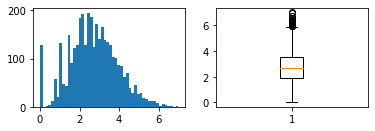

For the transformed feature of  B_avg_BODY_att
Number of outliers is: 101
The score threshold is: 2


In [18]:
#square root trans   
plt.subplot(2,2,1)
plt.hist(blue_cont['B_avg_BODY_att']**(1/2), bins = 50)
plt.subplot(2,2,2)
plt.boxplot(blue_cont['B_avg_BODY_att']**(1/2))
plt.show()

threshold = 2
z_scores = zscore(blue_cont['B_avg_BODY_att']**(1/2))
print('For the transformed feature of ', 'B_avg_BODY_att')
print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

print("The score threshold is: {}".format(threshold))

We transform all continuous features with square root function.  

In [19]:
for feature in blue_cont.columns:
    #blue_cont.loc[:,feature] = winsorize(blue_cont.loc[:,feature], limits = .025)
    blue_cont.loc[:,feature] = (blue_cont.loc[:,feature])**(1/2)

for feature in red_cont.columns:
    #red_cont.loc[:,feature] = winsorize(red_cont.loc[:,feature], limits = .025)
    red_cont.loc[:,feature] = (red_cont.loc[:,feature])**(1/2)

In [20]:
# uncomment to look at transfored blue feature distribution

#plt.figure(figsize=(20,33))
#i=1
#for feature in blue_cont.columns:
#    plt.subplot(13,5,i)
#    
#    plt.hist((blue_cont.loc[:,feature]), bins = 50)
#    plt.title(feature)
#    i=i+1
#plt.tight_layout()
#plt.show()

In [21]:
# uncomment to look at transfored blue feature distribution

#plt.figure(figsize=(20,33))
#i=1
#for feature in red_cont.columns:
#   plt.subplot(13,5,i)
    
#    plt.hist((red_cont.loc[:,feature]), bins = 50)
#    plt.title(feature)
#    i=i+1
#plt.tight_layout()
#plt.show()

We want to find features that are correlated with the target and have relatively low correlation with each other.  We can visualize it with heatmap.  

In [22]:
blue_cont['Winner'] = pd.get_dummies(df['Winner'], drop_first = True)
red_cont['Winner'] = blue_cont['Winner']
blue_cat['Winner'] = blue_cont['Winner']
red_cat['Winner'] = blue_cont['Winner']

fighter_features = [['blue_cont', 'red_cont', 'blue_cat', 'red_cat']]

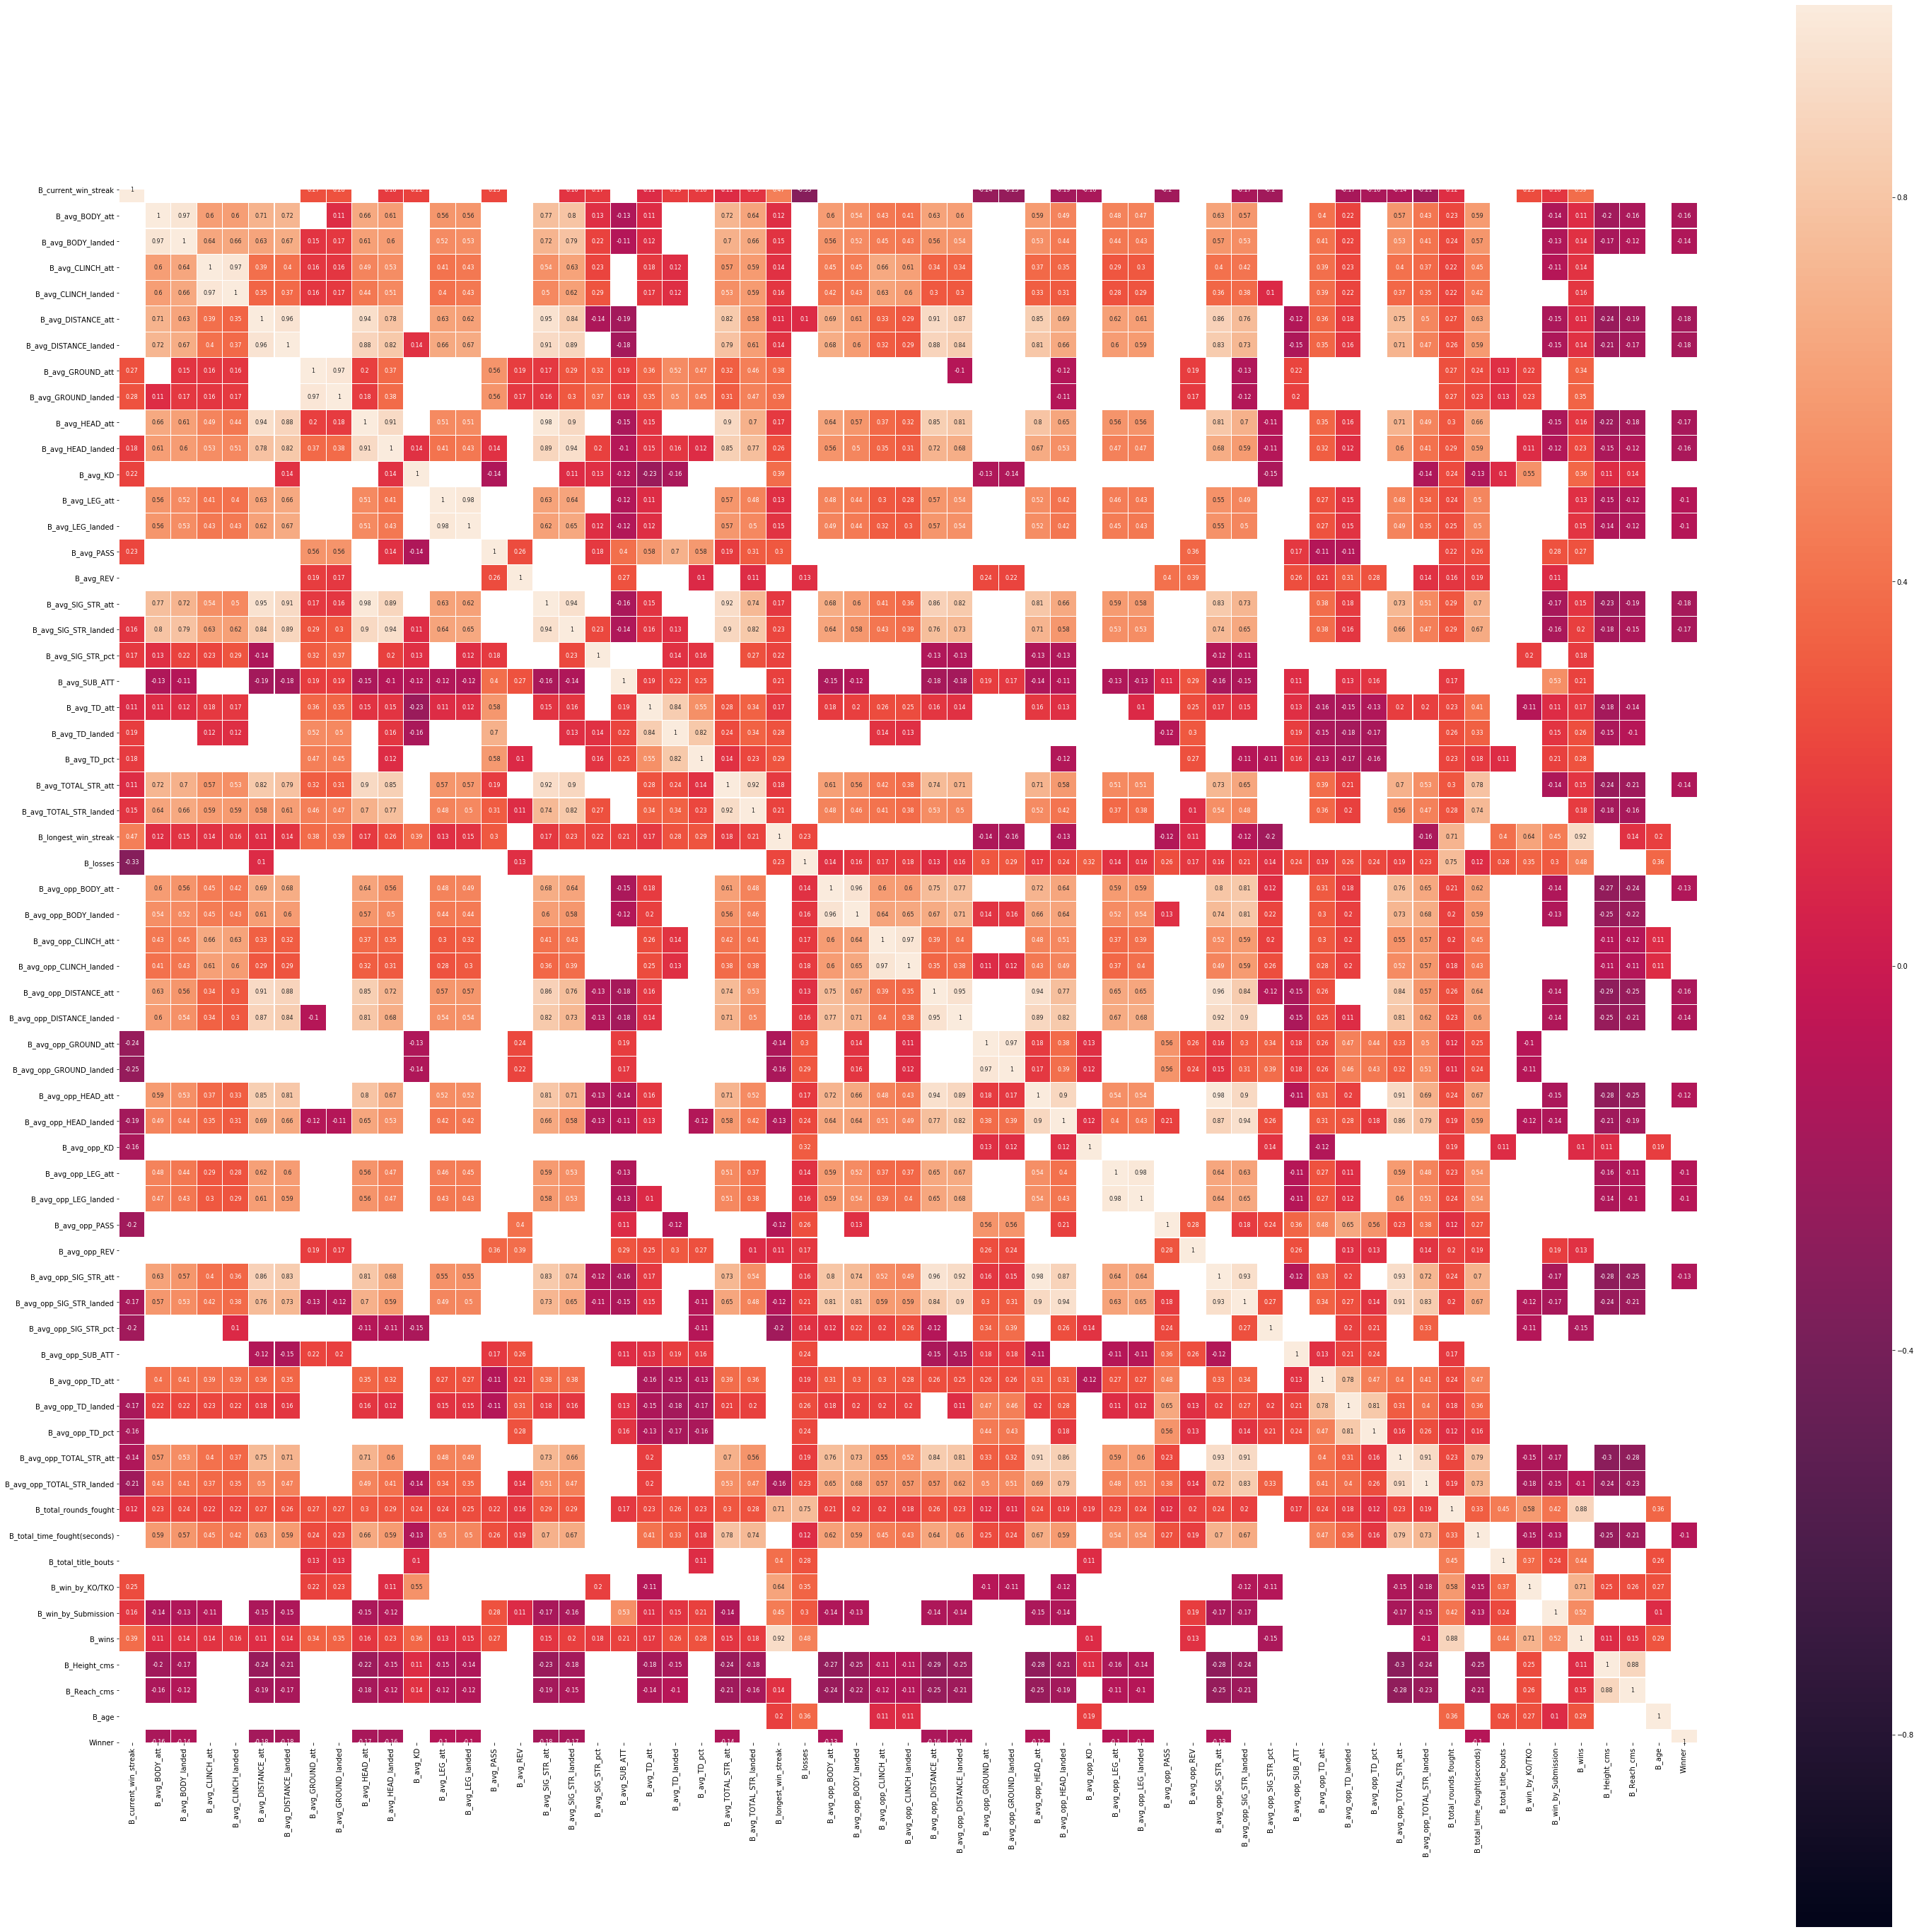

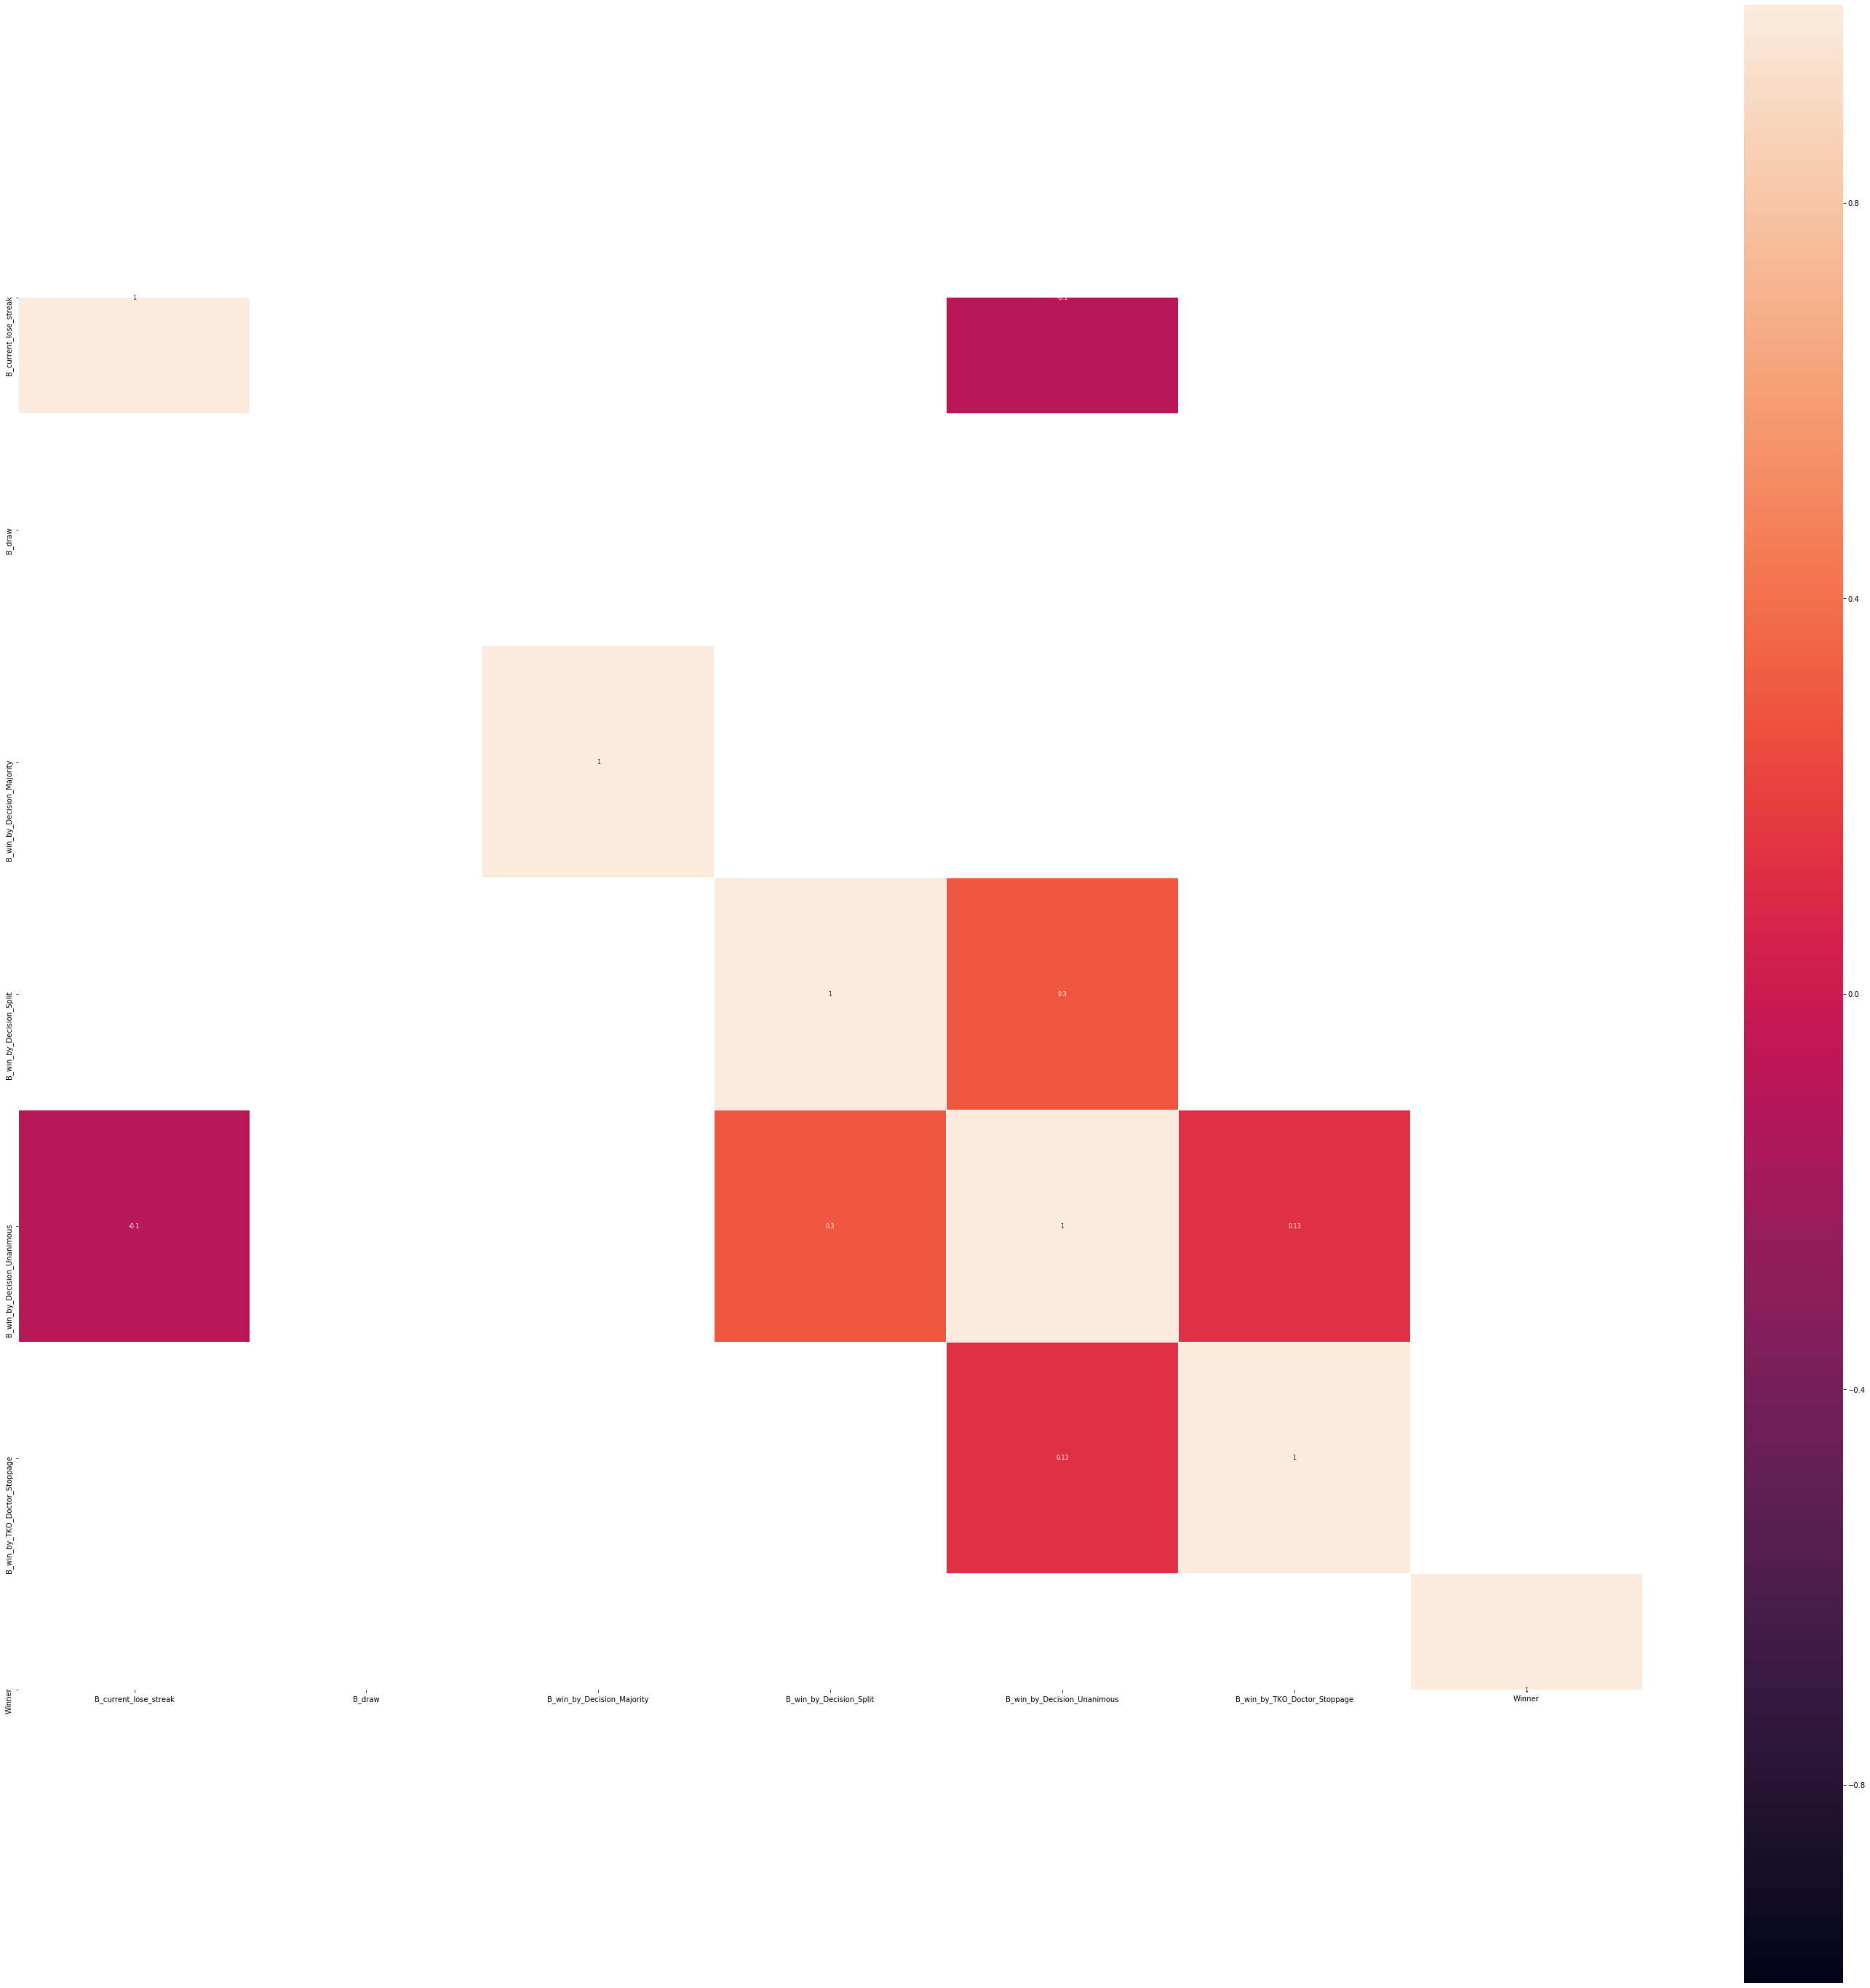

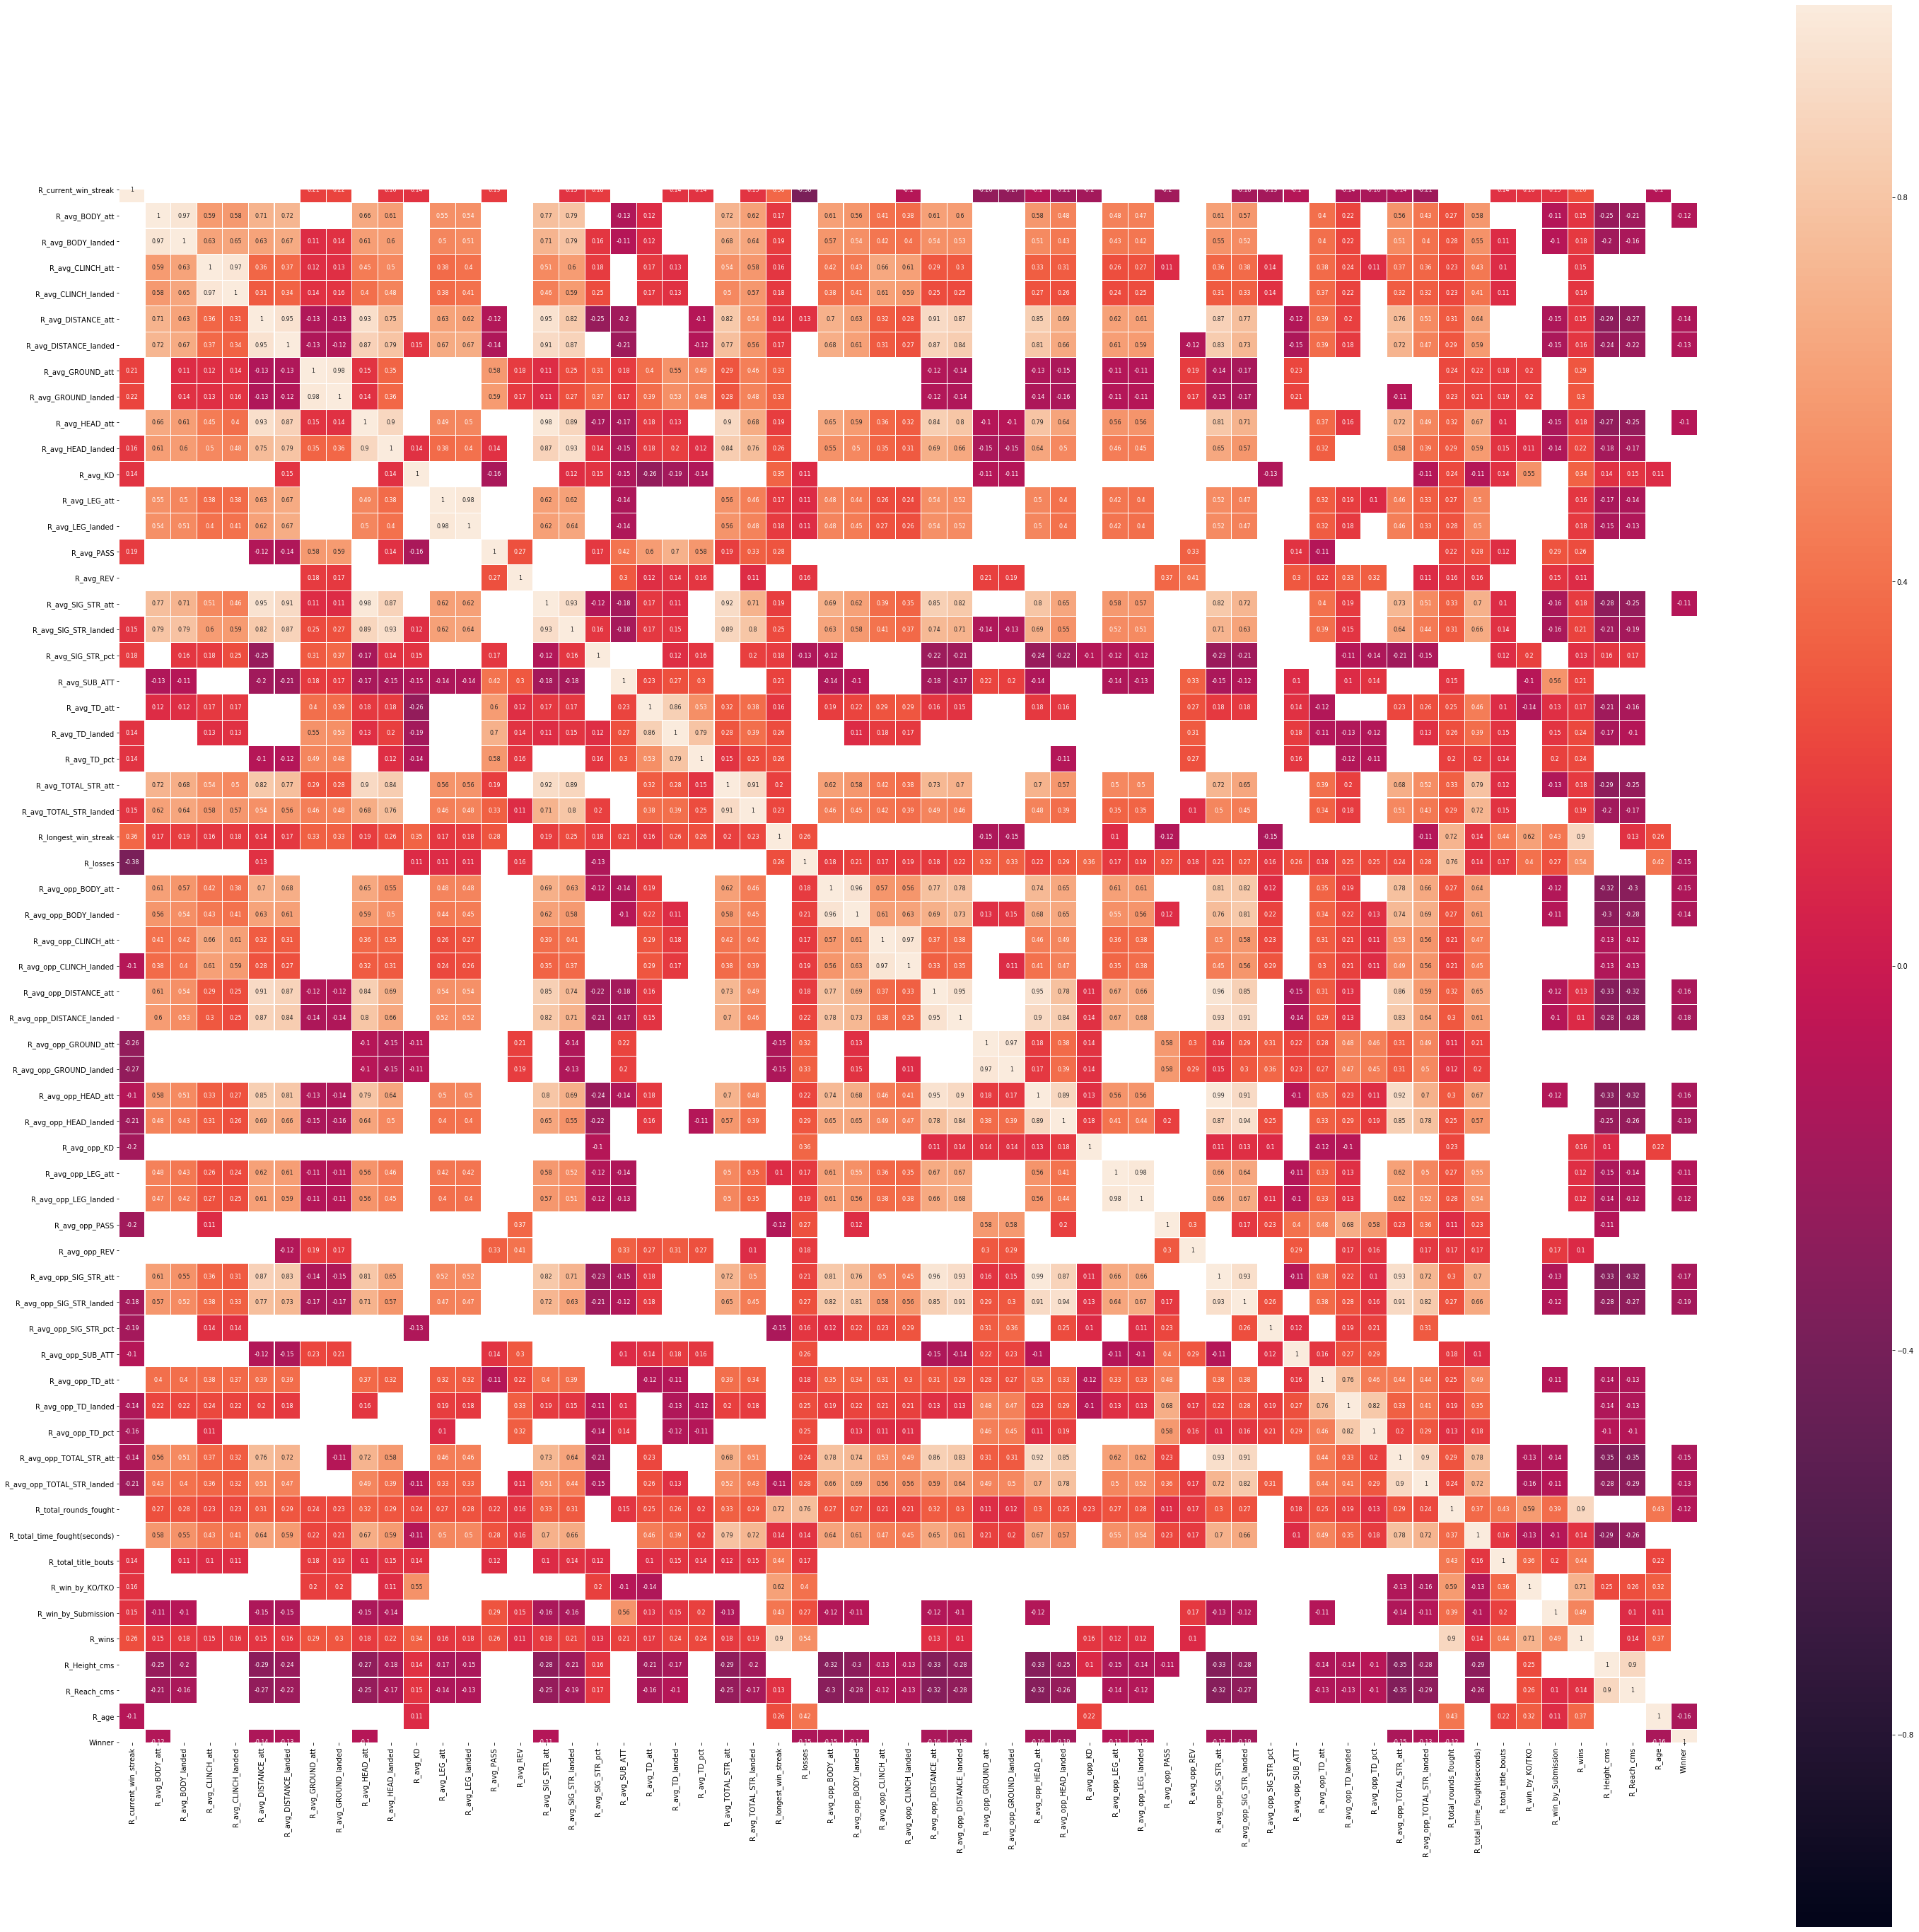

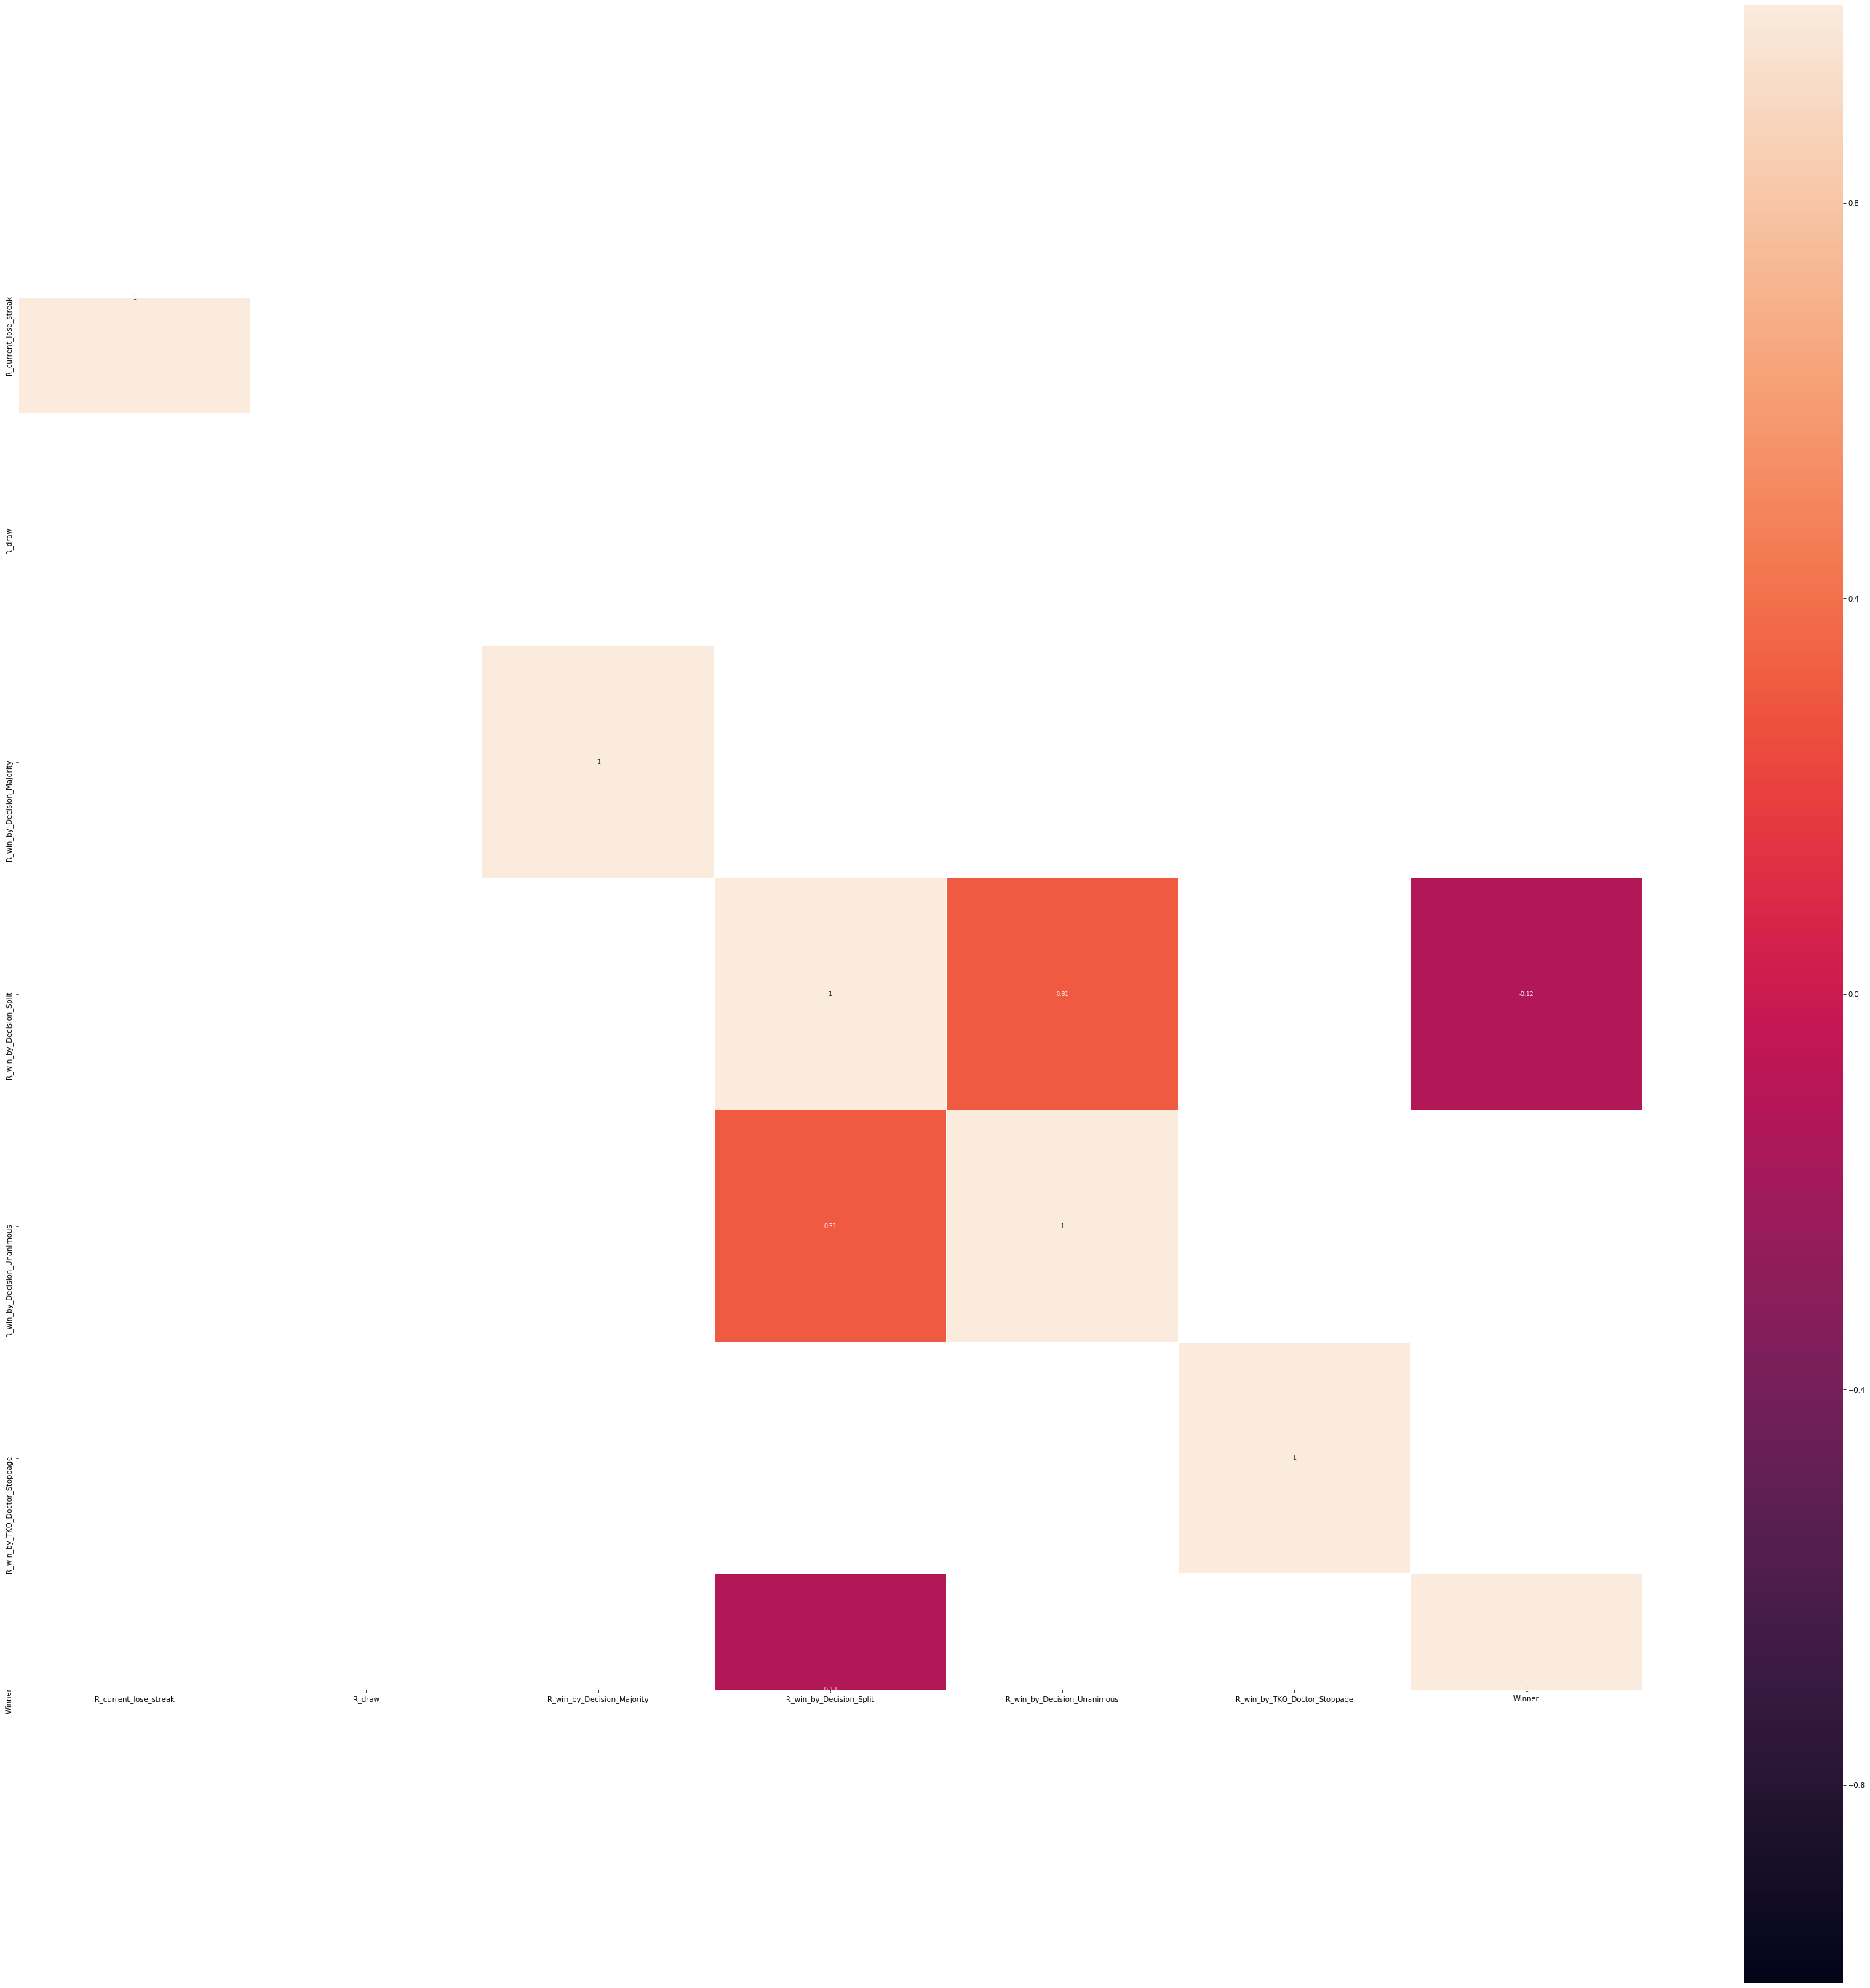

In [23]:

plt.figure(figsize=(50,50))
corr = blue_cont.corr()
sns.heatmap(corr[(corr>= 0.1)|(corr <= -0.1)],
    vmax = 1.0, vmin = -1.0, linewidths = 0.1,
    annot=True, annot_kws={'size':8}, square=True);
plt.show()

plt.figure(figsize=(50,50))
corr = blue_cat.corr()
sns.heatmap(corr[(corr>= 0.1)|(corr <= -0.1)],
    vmax = 1.0, vmin = -1.0, linewidths = 0.1,
    annot=True, annot_kws={'size':8}, square=True);
plt.show()

plt.figure(figsize=(50,50))
corr = red_cont.corr()
sns.heatmap(corr[(corr>= 0.1)|(corr <= -0.1)],
    vmax = 1.0, vmin = -1.0, linewidths = 0.1,
    annot=True, annot_kws={'size':8}, square=True);
plt.show()

plt.figure(figsize=(50,50))
corr = red_cat.corr()
sns.heatmap(corr[(corr>= 0.1)|(corr <= -0.1)],
    vmax = 1.0, vmin = -1.0, linewidths = 0.1,
    annot=True, annot_kws={'size':8}, square=True);
plt.show()

We can try to use all the continuous feature with more than 10 percent corrolation to the target to make predictions.   

We group blue and red cont_features together and group blue and red cat_features together

In [24]:
cont_features = pd.concat([blue_cont.iloc[:,:-1],red_cont.iloc[:,:]], axis = 1)
cat_features = pd.concat([blue_cat.iloc[:,:-1], red_cat.iloc[:,:-1]], axis = 1)
cat_features['no_of_rounds'] = df['no_of_rounds']
cat_features['title_bout'] = df['title_bout']

We Convert data in cat_features to string so it can be hot encoded.

In [25]:
# change data in cat_features into str type
for feature in cat_features.columns:
    for i in range(len(cat_features[feature])):
        #print(i)
        #print(feature)
        #print(cat_features[feature][i])
        cat_features.loc[i ,feature] = str(cat_features[feature][i])

In [26]:
cat_features = pd.get_dummies(cat_features, drop_first = True)

Now lets only use the continues feature which has more than 10% corrolation with the target

In [27]:
corr = cont_features[['B_avg_BODY_att','Winner']].corr()
corr

,B_avg_BODY_att,Winner
B_avg_BODY_att,1.000000,-0.161261
Winner,-0.161261,1.000000


In [28]:
# make a dataframe with features that have over 10% corr with target
Features_cont = pd.DataFrame()
for feature in cont_features.columns[:-1]:
    corr = cont_features[[feature,'Winner']].corr()
    corr_pct = corr.iloc[0][1]
    if (corr_pct >= .1) | (corr_pct <= -0.1):
        #print(feature ,corr_pct) 
        Features_cont[feature] = cont_features[feature]

In [29]:
len(Features_cont.columns)

39

In [30]:
Features_cont.columns

Index(['B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_DISTANCE_att',
       'B_avg_DISTANCE_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed',
       'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_SIG_STR_att',
       'B_avg_SIG_STR_landed', 'B_avg_TOTAL_STR_att', 'B_avg_opp_BODY_att',
       'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed',
       'B_avg_opp_HEAD_att', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed',
       'B_avg_opp_SIG_STR_att', 'B_total_time_fought(seconds)',
       'R_avg_BODY_att', 'R_avg_DISTANCE_att', 'R_avg_DISTANCE_landed',
       'R_avg_HEAD_att', 'R_avg_SIG_STR_att', 'R_losses', 'R_avg_opp_BODY_att',
       'R_avg_opp_BODY_landed', 'R_avg_opp_DISTANCE_att',
       'R_avg_opp_DISTANCE_landed', 'R_avg_opp_HEAD_att',
       'R_avg_opp_HEAD_landed', 'R_avg_opp_LEG_att', 'R_avg_opp_LEG_landed',
       'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed',
       'R_avg_opp_TOTAL_STR_att', 'R_avg_opp_TOTAL_STR_landed',
       'R_total_rounds_fought', 'R_age'],
      dty

There are 40 continuous blue and red feature that have more than 10% corrolation to target. 

In [31]:
Features_cont['Winner'] = blue_cont['Winner']

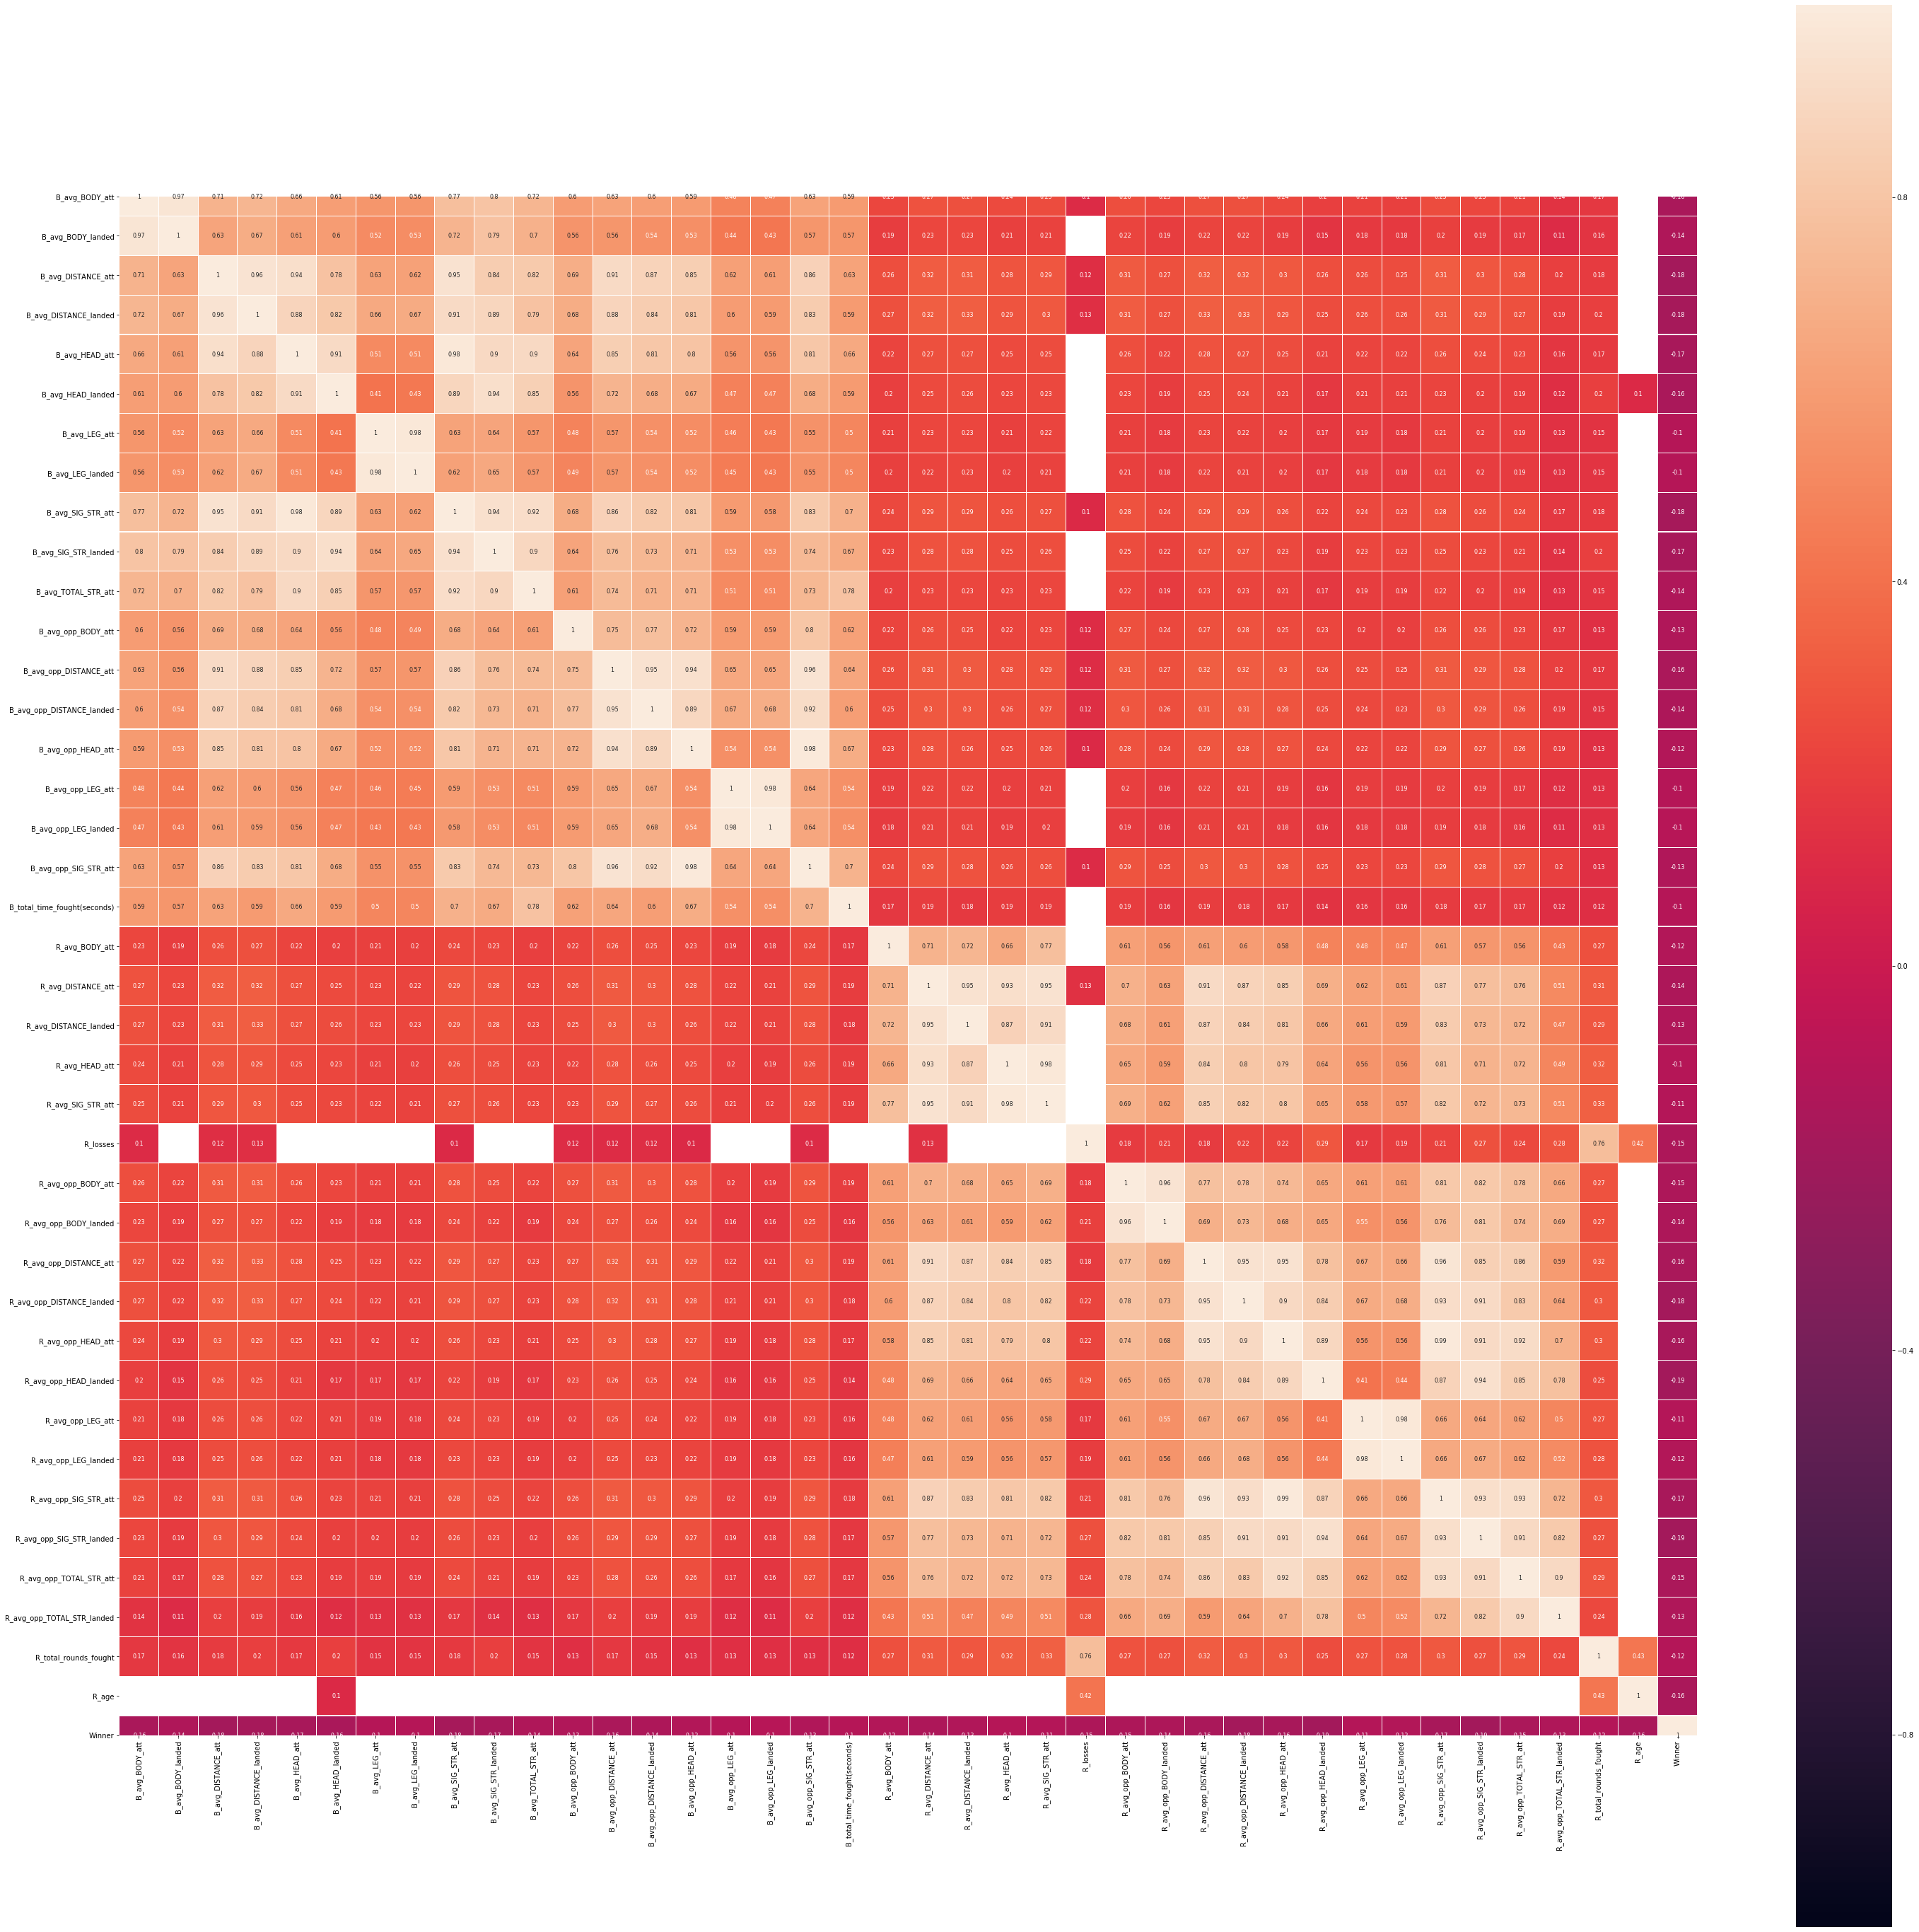

In [32]:
plt.figure(figsize=(50,50))
corr = Features_cont.corr()
sns.heatmap(corr[(corr>= 0.1)|(corr <= -0.1)],
    vmax = 1.0, vmin = -1.0, linewidths = 0.1,
    annot=True, annot_kws={'size':8}, square=True);
plt.show()

There are 40 continuous blue and red feature that have more than 10% corrolation to target. 

In [33]:
weight_class = df.iloc[:,137:150] 
fighter_stance = df.iloc[:,151:159] 

In [34]:
Data = pd.concat([Features_cont.iloc[:,:-1], cat_features, weight_class, fighter_stance], axis = 1)
len(Data.columns)

116

Now we have Data. We can give it to the models to predict on the target.  

In [35]:
Data.shape

(3592, 116)

In [36]:
target = pd.get_dummies(df['Winner'], drop_first = True)
Data['target'] = target

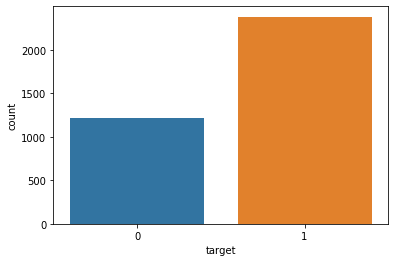

In [37]:
ax = sns.countplot(Data.target)
plt.show()

But first notice we have a slight class imbalance in the target.  In this case we don't have very many rows.  Therefore we can use oversampling to correct the imbalance.  

In [38]:
red_wins = Data.loc[Data['target']==1]
blue_wins = Data.loc[Data['target']==0]

In [39]:
print(blue_wins.shape, red_wins.shape)

(1212, 117) (2380, 117)


In [40]:
# Implementing Oversampling to deal with imbalance
X = Data.iloc[:,:-1]
y = Data.target
smk = SMOTETomek(random_state=42)
X_res, y_res = smk.fit_sample(X,y)

In [41]:
print(X_res.shape, y_res.shape)

(4662, 116) (4662,)


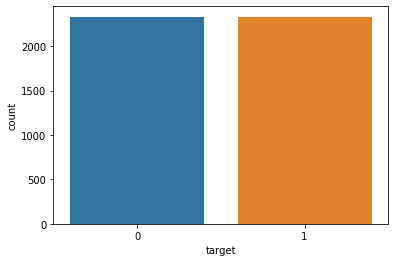

In [42]:
ax = sns.countplot(y_res)
plt.show()

Class imbalance addressed

In [43]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

values = df.Winner.value_counts()
labels = values.index
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

The UFC has its own model that predicts the higher ranked fighter.  The fighter favored to win always fights in red corner.  If we choose red every time, we would be correct 66.3% of the time.  This is our baseline.  Let’s see if we can make a model that performs better than the UFC model.

In [44]:
X_res.shape

(4662, 116)

In [45]:
y_res.shape

(4662,)

In [46]:
import warnings
warnings.filterwarnings('ignore')

We can try a random forest model first 

In [47]:
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X_res, y_res, cv=10))
print(cross_val_score(rfc, X_res, y_res, cv=10).mean())

[0.61884368 0.60599572 0.65450644 0.66094421 0.57725322 0.81974249
 0.87553648 0.92274678 0.95922747 0.96566524]
0.7514557351738336


We should get an accuracy of 75%

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
x_train, x_test, y_train, y_test = train_test_split(X_res,y_res,random_state =42)#

rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
metrics.accuracy_score(y_test,y_pred)

0.7512864493996569

Lets take a look at the confusion matrix and check the errors.

In [49]:
from sklearn.metrics import confusion_matrix
rfc_matrix = confusion_matrix(y_test, y_pred)
rfc_matrix

array([[465, 128],
       [162, 411]], dtype=int64)

In [50]:
TN = rfc_matrix[0][0]
FP = rfc_matrix[0][1]
FN = rfc_matrix[1][0]
TP = rfc_matrix[1][1]
total = TN + FP + FN + TP

In [51]:
Accuracy = (TP+TN)/total #overall classified correctly
Misclassification = 1-Accuracy# overall classified wrong
True_Positive_rate = TP/(FN+TP)#  actually yes, and predict yes - Sensitivity
False_Positive_rate = FP/(TN+FP)# actually no, but predict yes
True_Negative_rate = TN/(TN+FP)#  actually no, and predict no  - Specificity
False_Negative_rate = FN/(FN+TP)# actually yes, but predict no
Precision = TP/(FP+TP)# predicted yes, and actually yes


In [52]:
print('Accuracy            : ', Accuracy) 
print('Misclassification   : ', Misclassification,'\n')
print('False_Positive_rate : ', False_Positive_rate)
print('False_Negative_rate : ', False_Negative_rate,'\n')
print('Sensitivity  : ', True_Positive_rate)
print('Specificity  : ', True_Negative_rate)
print('Precision    : ', Precision)

Accuracy            :  0.7512864493996569
Misclassification   :  0.24871355060034306 

False_Positive_rate :  0.21585160202360876
False_Negative_rate :  0.28272251308900526 

Sensitivity  :  0.7172774869109948
Specificity  :  0.7841483979763912
Precision    :  0.7625231910946196


Let's try decision tree

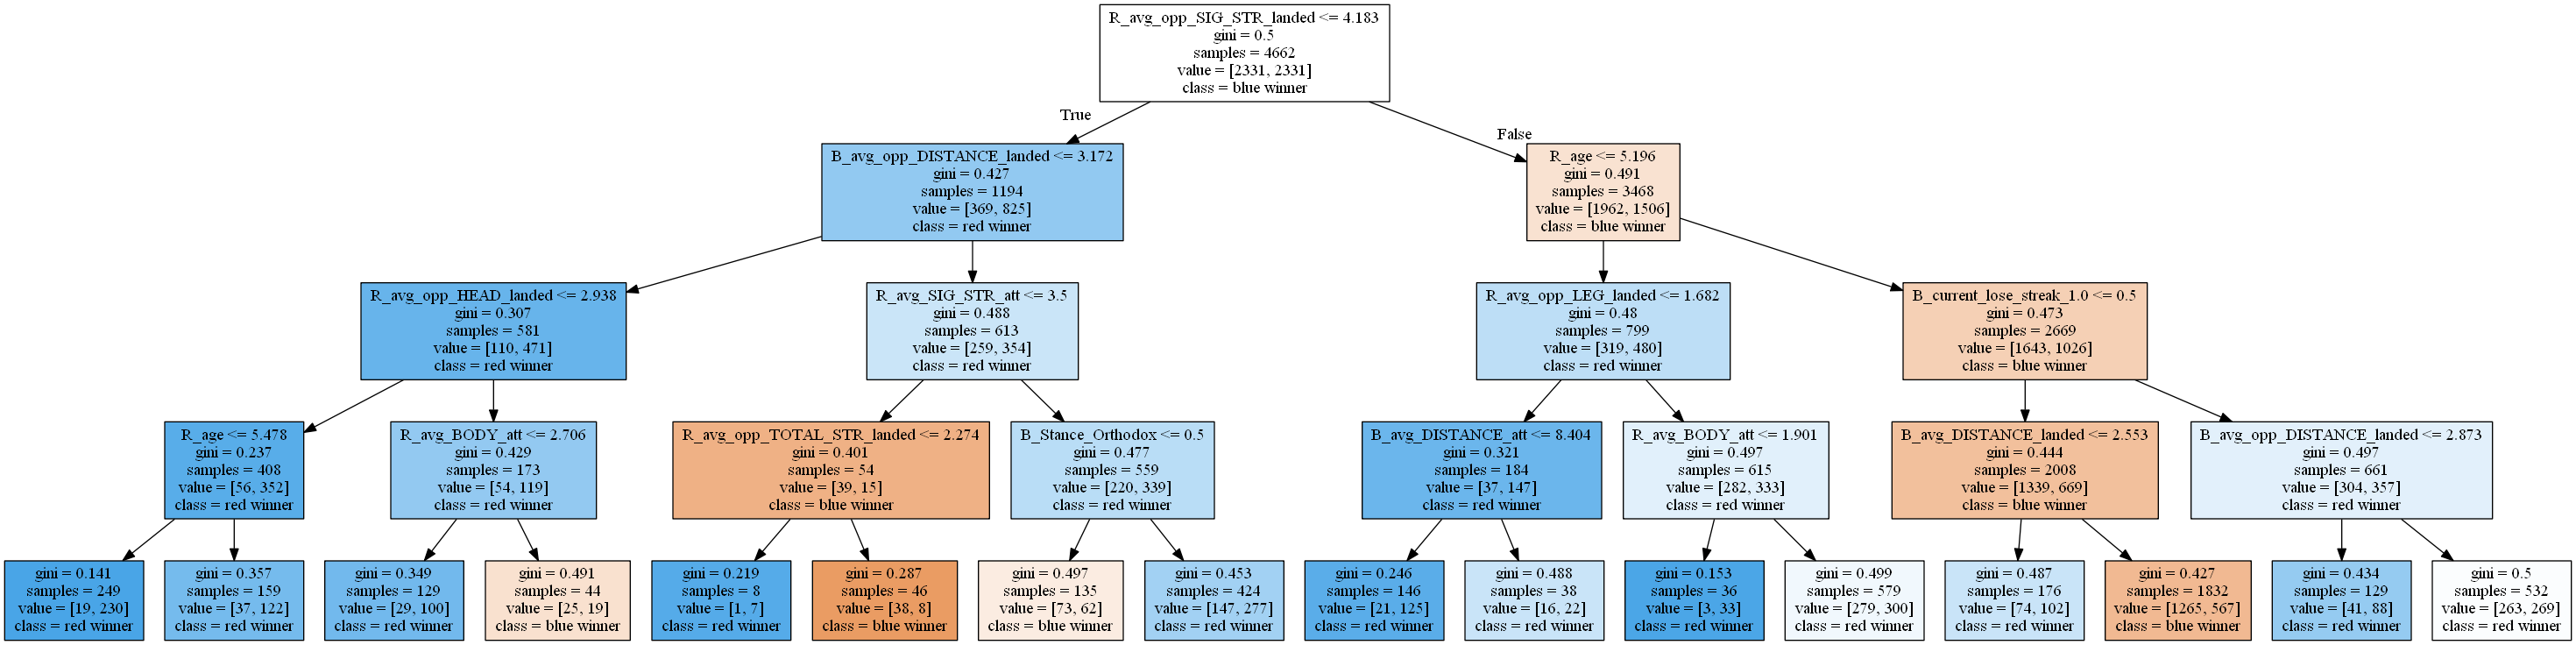

In [53]:
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=116,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(X_res, y_res)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['blue winner', 'red winner'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [54]:
cross_val_score(decision_tree, X_res, y_res, cv=10).mean()

0.6212308498221687

In [55]:
decision_tree.fit(x_train, y_train)
y_pred_tree = decision_tree.predict(x_test)
metrics.accuracy_score(y_test,y_pred_tree)

0.6337907375643225

In [56]:
tree_matrix = confusion_matrix(y_test, y_pred_tree)
tree_matrix

array([[421, 172],
       [255, 318]], dtype=int64)

In [57]:
TN = tree_matrix[0][0]
FP = tree_matrix[0][1]
FN = tree_matrix[1][0]
TP = tree_matrix[1][1]
total = TN + FP + FN + TP

Accuracy = (TP+TN)/total #overall classified correctly
Misclassification = 1-Accuracy# overall classified wrong
True_Positive_rate = TP/(FN+TP)#  actually yes, and predict yes - Sensitivity
False_Positive_rate = FP/(TN+FP)# actually no, but predict yes
True_Negative_rate = TN/(TN+FP)#  actually no, and predict no  - Specificity
False_Negative_rate = FN/(FN+TP)# actually yes, but predict no
Precision = TP/(FP+TP)# predicted yes, and actually yes

In [58]:
print('Accuracy            : ', Accuracy) 
print('Misclassification   : ', Misclassification,'\n')
print('False_Positive_rate : ', False_Positive_rate)
print('False_Negative_rate : ', False_Negative_rate,'\n')
print('Sensitivity  : ', True_Positive_rate)
print('Specificity  : ', True_Negative_rate)
print('Precision    : ', Precision)

Accuracy            :  0.6337907375643225
Misclassification   :  0.36620926243567753 

False_Positive_rate :  0.2900505902192243
False_Negative_rate :  0.44502617801047123 

Sensitivity  :  0.5549738219895288
Specificity  :  0.7099494097807757
Precision    :  0.6489795918367347


Let's try support vector machines 

In [59]:

from sklearn.svm import SVC
svc = SVC()
X = X_res.sample(frac=0.4, replace=True, random_state=1)
Y = y_res.sample(frac=0.4, replace=True, random_state=1)
svc.fit(X,Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
cross_val_score(svc, X, Y, cv=10).mean()

0.650445632798574

In [61]:
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
metrics.accuracy_score(y_test,y_pred)

0.6552315608919382

In [62]:
svc_matrix = confusion_matrix(y_test, y_pred)
svc_matrix

array([[443, 150],
       [252, 321]], dtype=int64)

In [63]:
TN = svc_matrix[0][0]
FP = svc_matrix[0][1]
FN = svc_matrix[1][0]
TP = svc_matrix[1][1]
total = TN + FP + FN + TP

Accuracy = (TP+TN)/total #overall classified correctly
Misclassification = 1-Accuracy# overall classified wrong
True_Positive_rate = TP/(FN+TP)#  actually yes, and predict yes - Sensitivity
False_Positive_rate = FP/(TN+FP)# actually no, but predict yes
True_Negative_rate = TN/(TN+FP)#  actually no, and predict no  - Specificity
False_Negative_rate = FN/(FN+TP)# actually yes, but predict no
Precision = TP/(FP+TP)# predicted yes, and actually yes

In [64]:
print('Accuracy            : ', Accuracy) 
print('Misclassification   : ', Misclassification,'\n')
print('False_Positive_rate : ', False_Positive_rate)
print('False_Negative_rate : ', False_Negative_rate,'\n')
print('Sensitivity  : ', True_Positive_rate)
print('Specificity  : ', True_Negative_rate)
print('Precision    : ', Precision)

Accuracy            :  0.6552315608919382
Misclassification   :  0.34476843910806176 

False_Positive_rate :  0.25295109612141653
False_Negative_rate :  0.4397905759162304 

Sensitivity  :  0.5602094240837696
Specificity  :  0.7470489038785835
Precision    :  0.6815286624203821


We can look at the prediction rates and see that our random forest model performed the best.  It has the high cross val score and Accuracy.  It also has the lowest false positive and false negative error rates. The random forest model had the best scores across the board on all the evaluation scores.   